## Exercise 06 — Scatter Matrix

In [87]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

con = sqlite3.connect('../data/checking-logs.sqlite')

In [88]:

test_users = pd.read_sql("SELECT DISTINCT uid FROM pageviews WHERE uid LIKE 'user_%'", con)
test_user_list = test_users['uid'].tolist()

In [89]:
df_pv = pd.read_sql("""
    SELECT uid, COUNT(datetime) AS pageviews
    FROM pageviews
    WHERE uid LIKE 'user_%'
    GROUP BY uid
""", con)
df_pv = df_pv[df_pv['uid'].isin(test_user_list)]


df_commits = pd.read_sql("""
    SELECT uid, COUNT(timestamp) AS num_commits
    FROM checker
    WHERE uid LIKE 'user_%' AND labname != 'project1'
    GROUP BY uid
""", con)
df_commits = df_commits[df_commits['uid'].isin(test_user_list)]


df_data = pd.read_sql("""
    SELECT uid, test.labname, MIN(timestamp) as first_commit, deadlines
    FROM checker test
    LEFT JOIN deadlines ON test.labname = deadlines.labs
    WHERE uid LIKE 'user_%' AND labname != 'project1'
    GROUP BY uid, labname
""", con)
df_data = df_data[df_data['uid'].isin(test_user_list)]

In [90]:
df_data['first_commit'] = pd.to_datetime(df_data['first_commit'])
df_data['deadlines'] = pd.to_datetime(df_data['deadlines'], unit='s') 
df_data['diff'] = (df_data['first_commit'] - df_data['deadlines']).dt.total_seconds() / 3600
df_avg_diff = df_data.groupby('uid')['diff'].mean().reset_index(name='avg_diff')


df_final = df_avg_diff.merge(df_pv, on='uid', how='inner').merge(df_commits, on='uid', how='inner')
df_final.set_index('uid', inplace=True)
df_final = df_final[['avg_diff', 'pageviews', 'num_commits']]



In [103]:
df_final.corr(numeric_only=True)

,avg_diff,pageviews,num_commits
avg_diff,1.000000,-0.279143,-0.307602
pageviews,-0.279143,1.000000,-0.163348
num_commits,-0.307602,-0.163348,1.000000


In [91]:
con.close()

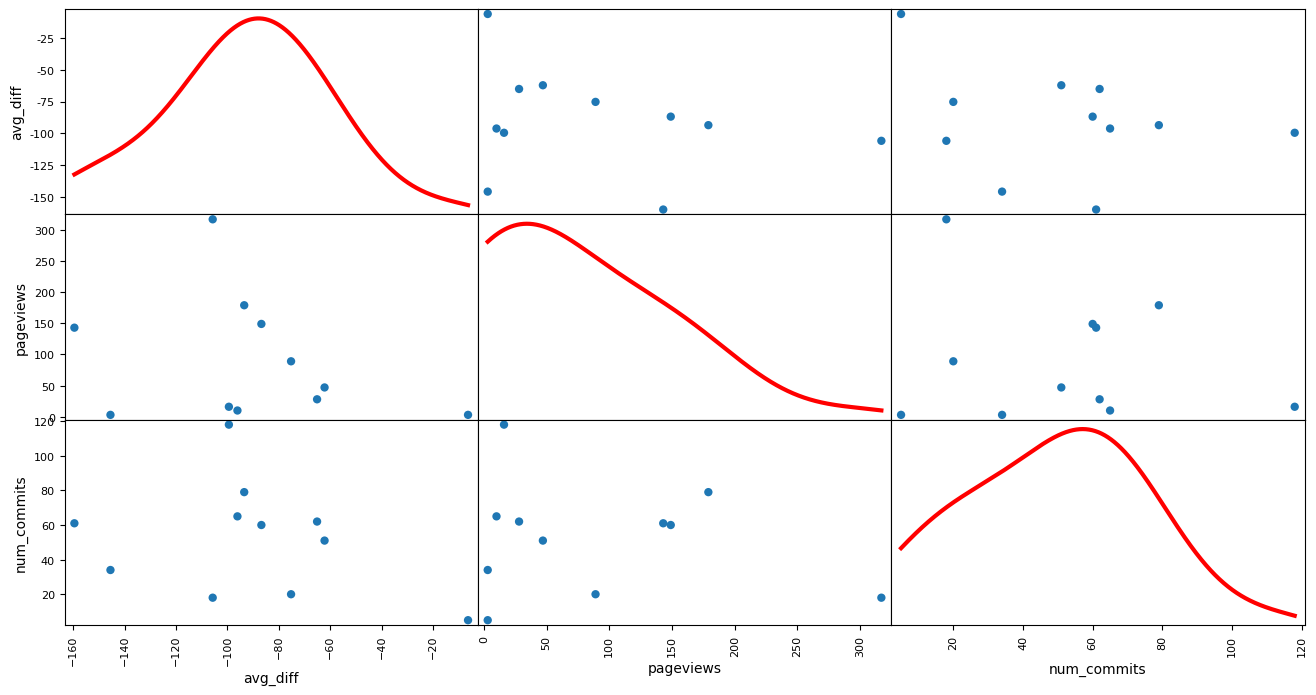

In [107]:
axes = scatter_matrix(df_final,diagonal='kde',figsize=(16,8),marker=200, alpha=1)
for ax in axes.ravel():
    for line in ax.lines:
        line.set_linewidth(3)
        line.set_color('red')

1. "Can we say that if a user has a low number of pageviews, then they likely have a low number of commits?"
**The answer is no.**

2. "Can we say that if a user has a low number of pageviews, then they likely have a small average difference between the first commit and the lab deadline?"
**The answer is no.**

3. "Can we say that there are many users with a low number of commits and a few with a high number of commits?"
**The answer is yes.**

4. "Can we say that there are many users with a small average difference and a few with a large average difference?"
**The answer is no.**